In [1]:
from init_analysis import *



In [3]:


avg_graphs = dict()
graph_list = list()
label = list()
hemi = list()

df = pd.DataFrame()

# Loop over subjects
for i, subject_file in enumerate(subject_jsons):
    #try:
    with open(subject_file, 'r') as f:
        subject_json = json.load(f)

    # Set step parameters
    thresh = 1
    av_json['parameters']['threshold'] = thresh
    av_json['needs'] = f'event_network_thresh_{thresh}'
    av_json['type'] = 'avalanches'
    
    # Load nodes
    dmeta = subject_json[av_json['needs']]['act_map_nodes']
    nodes = my.get_needed_derivative(dmeta, subject_json, project)
    
    # Load edges
    dmeta = subject_json[av_json['needs']]['act_map_edges']
    edges = my.get_needed_derivative(dmeta, subject_json, project)
    
    # Extract label
    condition = subject_json['init']['condition']
    if 'cohort' in condition:
        condition = re.sub(r'_cohort\d+', '', condition)

    G = my.make_graph(nodes, edges, condition)
    G.remove_edges_from(nx.selfloop_edges(G))

    # Separate nodes into hemispheres
    left_nodes = [n for n in G.nodes if 'left' in n.lower()]
    right_nodes = [n for n in G.nodes if 'right' in n.lower()]
    
    GG = [G.subgraph(left_nodes).copy(), G.subgraph(right_nodes).copy()]
    lr_label = ['left', 'right']
    for i,g in enumerate(GG):
        g = nx.relabel_nodes(g, {node: node.split(' ')[0] for node in g.nodes()})
        g.graph['condition'] = condition + '/' + lr_label[i]
        g.graph['hemisphere'] = lr_label[i]
        graph_list.append(g)
        hemi.append(lr_label[i])
        label.append(condition)

avg_graphs = my.average_graphs_by_condition(graph_list, label)

key = [g.graph['condition'] for g in graph_list]
df = pd.DataFrame({'keys' : key, 'cond': label, 'hemi': hemi})


/tmp/ipykernel_437000/2067548552.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_properties_df = pd.concat([edge_properties_df, row], ignore_index = True)#.append(, ignore_index=True)
/tmp/ipykernel_437000/2067548552.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  asymm_df = pd.concat([asymm_df, row], ignore_index = True)


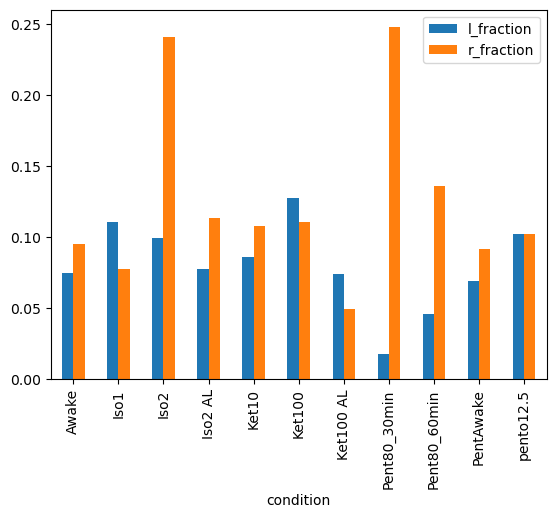

In [97]:
#check left-right asymettry of weights
edge_properties_df = pd.DataFrame(columns = ['condition', 'source', 'target', 'left', 'right'])
zero_factor = 10**-7

for key in np.unique(df['cond']):
    GL = avg_graphs[key + '/left']
    GR = avg_graphs[key + '/right']

    for source in GL.nodes():
        for target in GL.nodes():
            if GL.has_edge(source, target):
                Lweight = GL[source][target]['weight']
            else:
                Lweight = zero_factor
            if GR.has_edge(source, target):
                Rweight = GR[source][target]['weight']
            else:
                Rweight = zero_factor
            row = pd.DataFrame({'condition': key, 'source': source, 'target': target, 'left': Lweight, 'right': Rweight}, index = [0])
            edge_properties_df = pd.concat([edge_properties_df, row], ignore_index = True)#.append(, ignore_index=True)

edge_properties_df['avg_lr'] = (edge_properties_df['left'] + edge_properties_df['right']) / 2
edge_properties_df = edge_properties_df.sort_values(['source','target'])

asymm_df = pd.DataFrame(columns = ['condition', 'left_zeros', 'right_zeros', 'asymmetry', 'total weights'])
ncols = int(np.ceil(np.sqrt(len(df['keys']))))
nrows = int(np.ceil(np.sqrt(len(df['keys']))))

for i,cond in enumerate(np.unique(df['cond'])):
    #ax = plt.subplot(nrows,ncols,i+1)

    lr_weights = edge_properties_df[edge_properties_df['condition'] == cond]
    #lr_weights.plot(ax= ax, x = 'left', y = 'right', kind = 'scatter', alpha = 0.5, title= cond, loglog = True, figsize = (20,20))
    #plot_reference_line()
  
    l_asymm = (lr_weights[(lr_weights['left'] == zero_factor) & (lr_weights['right'] > zero_factor)])
    r_asymm = (lr_weights[(lr_weights['left'] > zero_factor) & (lr_weights['right'] == zero_factor)])
    asymm =  (len(r_asymm)+1)/ (len(l_asymm)+1)
    row = pd.DataFrame({'condition': cond, 'left_zeros': len(l_asymm), 'right_zeros':len(r_asymm), 'asymmetry': asymm, 'total weights':len(lr_weights)}, index = [0])
    asymm_df = pd.concat([asymm_df, row], ignore_index = True)

asymm_df['l_fraction'] = asymm_df['left_zeros']/asymm_df['total weights']
asymm_df['r_fraction'] = asymm_df['right_zeros']/asymm_df['total weights']

ax = asymm_df.plot(x = 'condition', y = ['l_fraction', 'r_fraction'], kind = 'bar')

save_dir = my.check_if_dir_exists(result_dir / 'averaged_graphs' / 'figures')
ax.figure.savefig(save_dir +'/' + 'asymmetry_analysis.png')

 

In [59]:
#plot both hemispheres of the averaged graphs
save_name = 'LR_avg_graph'
avg_graphs_meta = dict()
avg_graphs_meta[save_name] = dict()
for key in np.unique(df['cond']):
    GL = avg_graphs[key + '/left']
    GL = nx.relabel_nodes(GL, {node: node + ' L' for node in GL.nodes()})

    GR = avg_graphs[key + '/right']
    GR = nx.relabel_nodes(GR, {node: node + ' R' for node in GR.nodes()})

    G = nx.union(GL, GR)
    fig = my.draw_weighted_graph(G, title = key, figsize = (5,5), show_fig = False)
    
    
    
    save_dir = result_dir / 'averaged_graphs' / key 
    if not os.path.exists(save_dir):
        Path(save_dir).mkdir(parents = True, exist_ok = True)
        
    #save the figure
    fig.savefig(str(save_dir) + '/' + save_name + '.png')
    plt.close(fig)
    
    #save the averaged graphs
    avg_graphs_meta[save_name][key] = {'path': str(save_dir) + '/' + save_name,
                                        'save_dir': str(save_dir),
                                        'save_name': save_name,
                                        'num_recs_for_avg': len([x for x in label if x == key]),
                                        'format' : 'gml',
                                        'num_nodes' : len(G.nodes()),
                                        'num_edges' : len(G.edges()),
                                        'directed' : nx.is_directed(G),
                                        'weighted' : nx.is_weighted(G),
                                        'connected' : nx.is_strongly_connected(G)
                                       }
    #save the graph as gephi file
    nx.write_gml(G, avg_graphs_meta[save_name][key]['path'] + '.' + avg_graphs_meta[save_name][key]['format'])
    
    
with open(str(result_dir / 'averaged_graphs/') + 'avg_graphs_meta.pkl', 'wb') as f:
    pickle.dump(avg_graphs_meta, f)    
    

In [135]:
# G = nx.read_gml(avg_graphs_meta[save_name][key]['path'] + '.' + avg_graphs_meta[save_name][key]['format'])
# G.nodes(data = True)

In [69]:
with open(str(result_dir / 'averaged_graphs/') + '/avg_graphs_meta.pkl', 'rb') as f:
    avg_graphs_meta = pickle.load(f)    

In [171]:
load_name = 'LR_avg_graph'
avg_graphs = dict()
for key in avg_graphs_meta[load_name].keys():
    G = nx.read_gml(avg_graphs_meta[load_name][key]['path'] + '.' + avg_graphs_meta[save_name][key]['format'])
    avg_graphs[key] = G


In [179]:
#average the LR hemispheres into one
graphs = dict()
for key in avg_graphs.keys():
    G = avg_graphs[key]
    LRnodes = {'L':list(), 'R': list()}
    for node in G.nodes():
        LRnodes[node[-1]].append(node)

    GL = G.subgraph(LRnodes['L'])
    GR = G.subgraph(LRnodes['R'])

    GL = nx.relabel_nodes(GL, {node: node[0:-1].strip() for node in GL.nodes()})
    GR = nx.relabel_nodes(GR, {node: node[0:-1].strip() for node in GR.nodes()})

    G = my.average_hemisphere_graphs(GL, GR)
    graphs[key] = G

#make sure all the nodes are the same
inter = set.intersection(*[set(G.nodes()) for G in graphs.values()])
for key in graphs.keys():
    graphs[key] = nx.subgraph(graphs[key], inter)
graph_list = [nx.subgraph(G, inter) for G in graph_list]   


#save the graphs as GML files
save_name = 'avg_graph'
avg_graphs_meta[save_name] = dict()
for key in graphs.keys():
    G = graphs[key]
    #save the averaged graphs
    save_dir = result_dir / 'averaged_graphs' / key 

    avg_graphs_meta[save_name][key] = {'path': str(save_dir) + '/' + save_name,
                                        'save_dir': str(save_dir),
                                        'save_name': save_name,
                                        'num_recs_for_avg': avg_graphs_meta['LR_avg_graph'][key]['num_recs_for_avg'],
                                        'format' : 'gml',
                                        'num_nodes' : len(G.nodes()),
                                        'num_edges' : len(G.edges()),
                                        'directed' : nx.is_directed(G),
                                        'weighted' : nx.is_weighted(G),
                                        'connected' : nx.is_strongly_connected(G)
                                       }

    #save the graph as gephi file
    nx.write_gml(G, avg_graphs_meta[save_name][key]['path'] + '.' + avg_graphs_meta[save_name][key]['format'])
    
    
with open(str(result_dir / 'averaged_graphs') + '/' + 'avg_graphs_meta.pkl', 'wb') as f:
    pickle.dump(avg_graphs_meta, f) 

In [38]:
with open(str(result_dir / 'averaged_graphs/') + '/avg_graphs_meta.pkl', 'rb') as f:
    avg_graphs_meta = pickle.load(f)  

load_name = 'avg_graph'
graphs = dict()
for key in avg_graphs_meta[load_name].keys():
    G = nx.read_gml(avg_graphs_meta[load_name][key]['path'] + '.' + avg_graphs_meta[load_name][key]['format'])
    graphs[key] = G

In [17]:
#calculate properties for the nodes
save_name = 'nodedf'
save_dir = result_dir / 'averaged_graphs/'

metrics = ['indegree' , 'outdegree', 'between', 'clustering', 'activation']
node_df = pd.DataFrame(columns = ['condition', 'node'] + metrics)
for key in graphs.keys():
    G = graphs[key]
    
    stats_df,G = my.calculate_node_proprties(G, key);
    node_df = pd.concat([node_df, stats_df]);
    graphs[key] = G

    #update the graph meta
    avg_graphs_meta['avg_graph'][key]['metrics'] = metrics

    #save the graph
    nx.write_gml(G, avg_graphs_meta[save_name][key]['path'] + '.' + avg_graphs_meta[save_name][key]['format'])


#save the node_df file
avg_graphs_meta[save_name] = {'path': str(save_dir) + '/' + save_name,
                                    'save_dir': str(save_dir),
                                    'save_name': save_name,
                                    'format' : 'csv',
                                    'num_cols' : node_df.shape[1],
                                    'num_rows' : node_df.shape[0]
                                   }

node_df.to_csv(avg_graphs_meta[save_name]['path'] + '.csv')


/tmp/ipykernel_822734/1955244535.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  node_df = pd.concat([node_df, stats_df]);


In [19]:
#calculate properties for the edges
save_name = 'edgedf'
save_dir = result_dir / 'averaged_graphs/'

conds = list(set(node_df['condition']))
edge_df = pd.DataFrame(columns = ['source_target'] + conds)
zero_factor = 10**-7

nodes = list(set(node_df['node']))

for c in conds:
    G = graphs[c]
    weight = list()
    st = list()
    for source in nodes:
        for target in nodes:
            st.append(source + '_' + target)
            if G.has_edge(source, target):
                weight.append(G[source][target]['weight'])
            else:
                weight.append(zero_factor)
                

    edge_df['source_target'] = st
    edge_df[c] = weight

            


#save the node_df file
avg_graphs_meta[save_name] = {'path': str(save_dir) + '/' + save_name,
                                    'save_dir': str(save_dir),
                                    'save_name': save_name,
                                    'format' : 'csv',
                                    'num_cols' : edge_df.shape[1],
                                    'num_rows' : edge_df.shape[0]
                                   }

edge_df.to_csv(avg_graphs_meta[save_name]['path'] + '.csv')


In [21]:
   
with open(str(result_dir / 'averaged_graphs') + '/' + 'avg_graphs_meta.pkl', 'wb') as f:
    pickle.dump(avg_graphs_meta, f) 

In [3]:
with open(str(result_dir / 'averaged_graphs') + '/avg_graphs_meta.pkl', 'rb') as f:
    avg_graphs_meta = pickle.load(f)  

edge_df = pd.read_csv(avg_graphs_meta['edgedf']['path'] + '.csv')
node_df = pd.read_csv(avg_graphs_meta['nodedf']['path'] + '.csv')

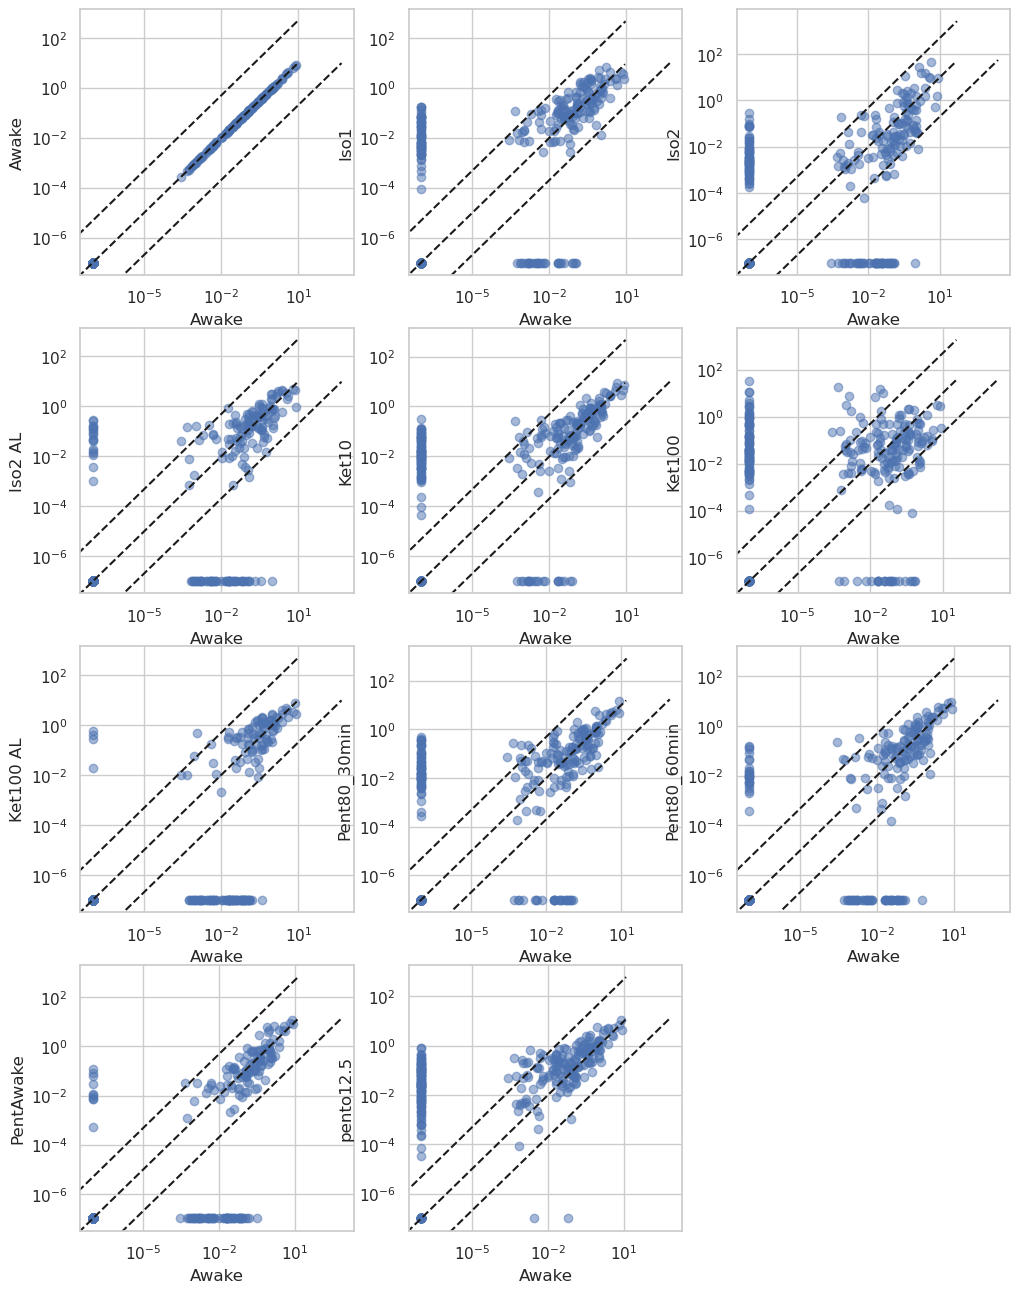

In [25]:
#plot weights against reference
conds = list(avg_graphs_meta['avg_graph'].keys())
ncols = int(np.ceil(3./4*np.sqrt(len(conds))))
nrows = int(np.ceil(4./3*np.sqrt(len(conds))))
count = 1
plt.figure(figsize = (ncols*4,nrows*4))
cond1 = reference 
cond1_weights = edge_df[cond1]



for j,cond2 in enumerate(conds):
    cond2_weights = edge_df[cond2]

    
    plt.subplot(nrows, ncols, count)
    count += 1
    plt.scatter(cond1_weights, cond2_weights, alpha = 0.5)
    my.plot_reference_line()
    my.plot_reference_line(slope = 50)
    my.plot_reference_line(slope = 1./50)
    plt.xscale('log')
    plt.yscale('log')
    #plt.title(cond1 + ' vs ' + cond2)
    plt.xlabel(cond1)
    plt.ylabel(cond2)
    ax = plt.gca()
    ax.get_legend().remove()

save_dir = my.check_if_dir_exists(str(result_dir / 'averaged_graphs') +'/figures/')
plt.savefig(save_dir + 'weights_comparison_reference=' + reference +  '.png')

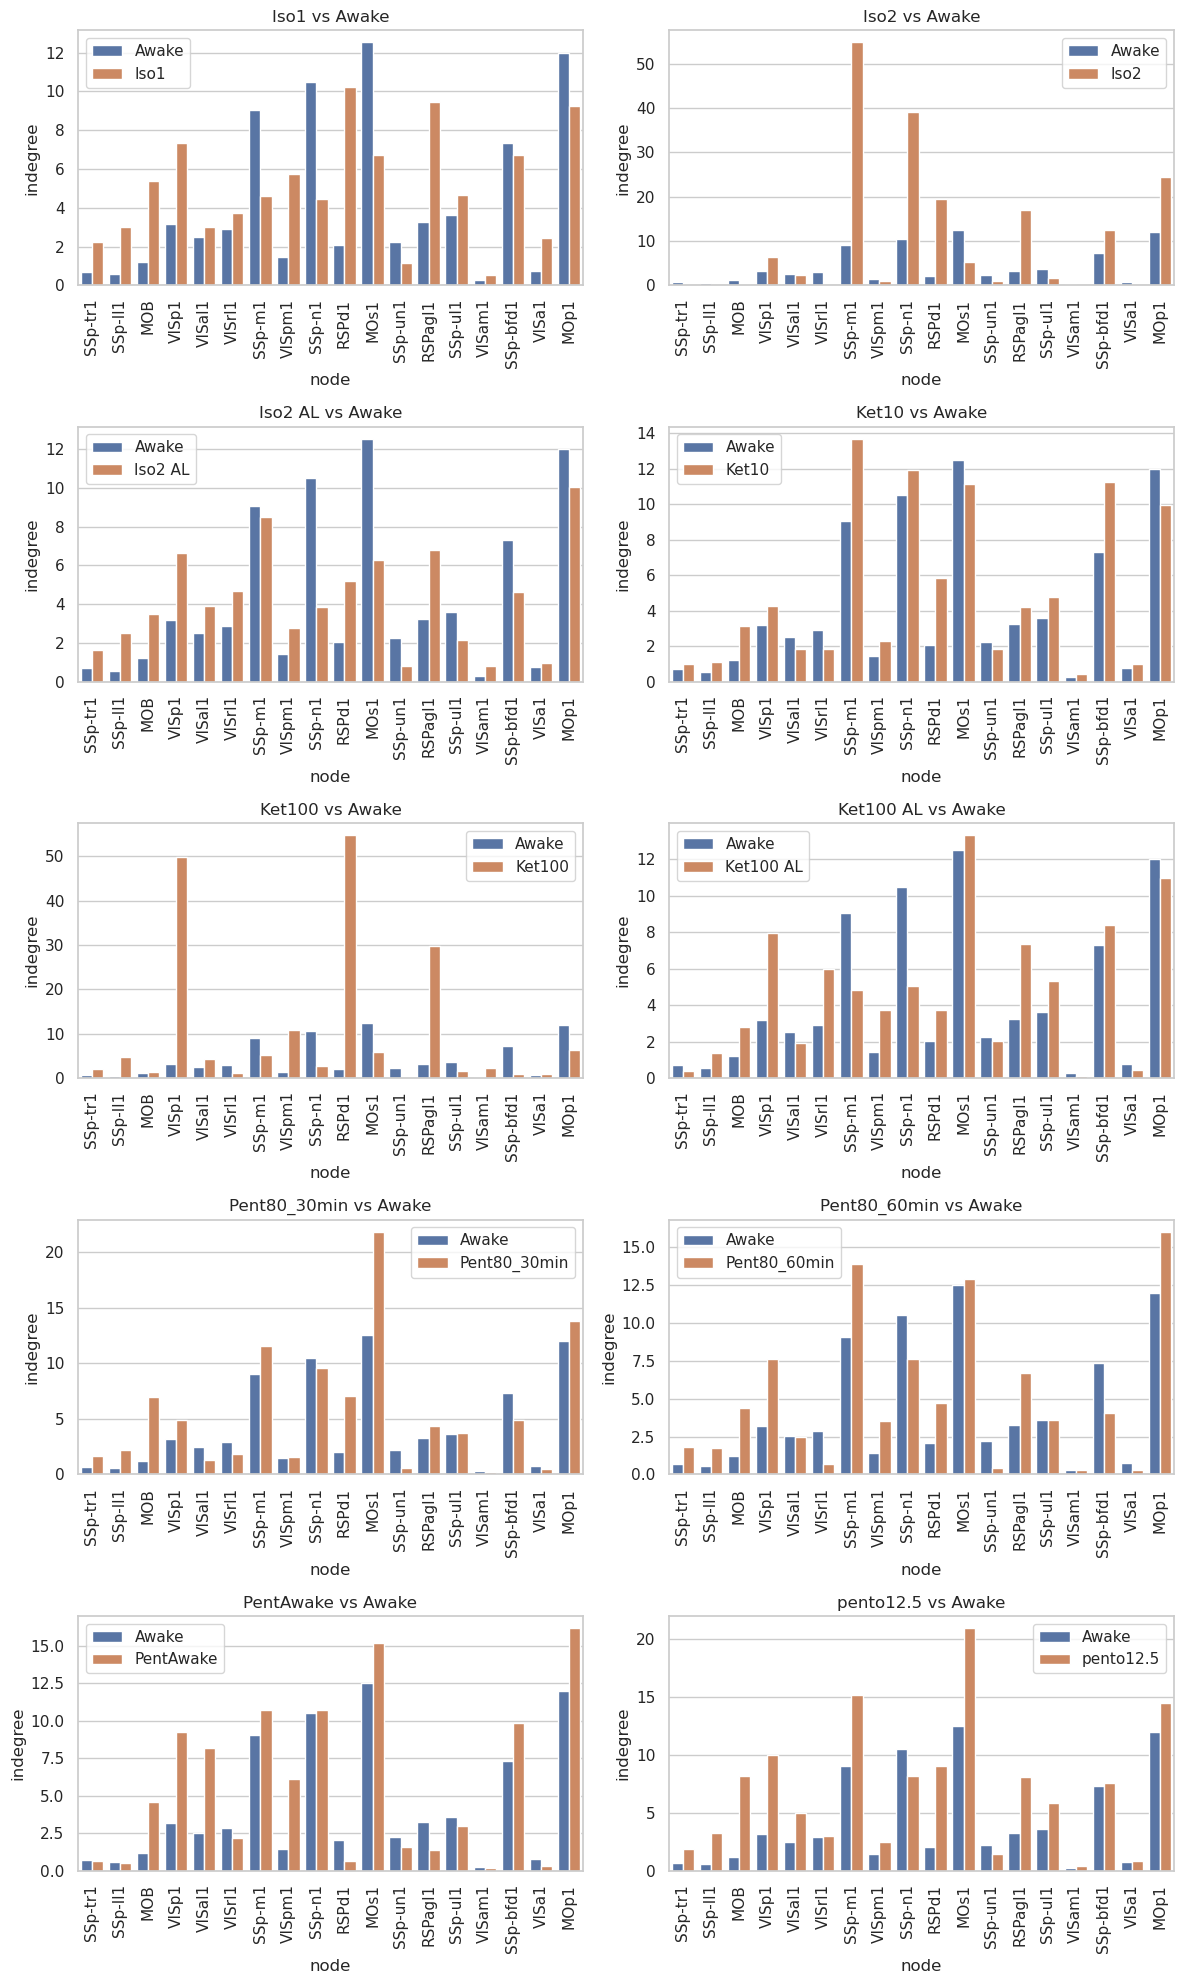

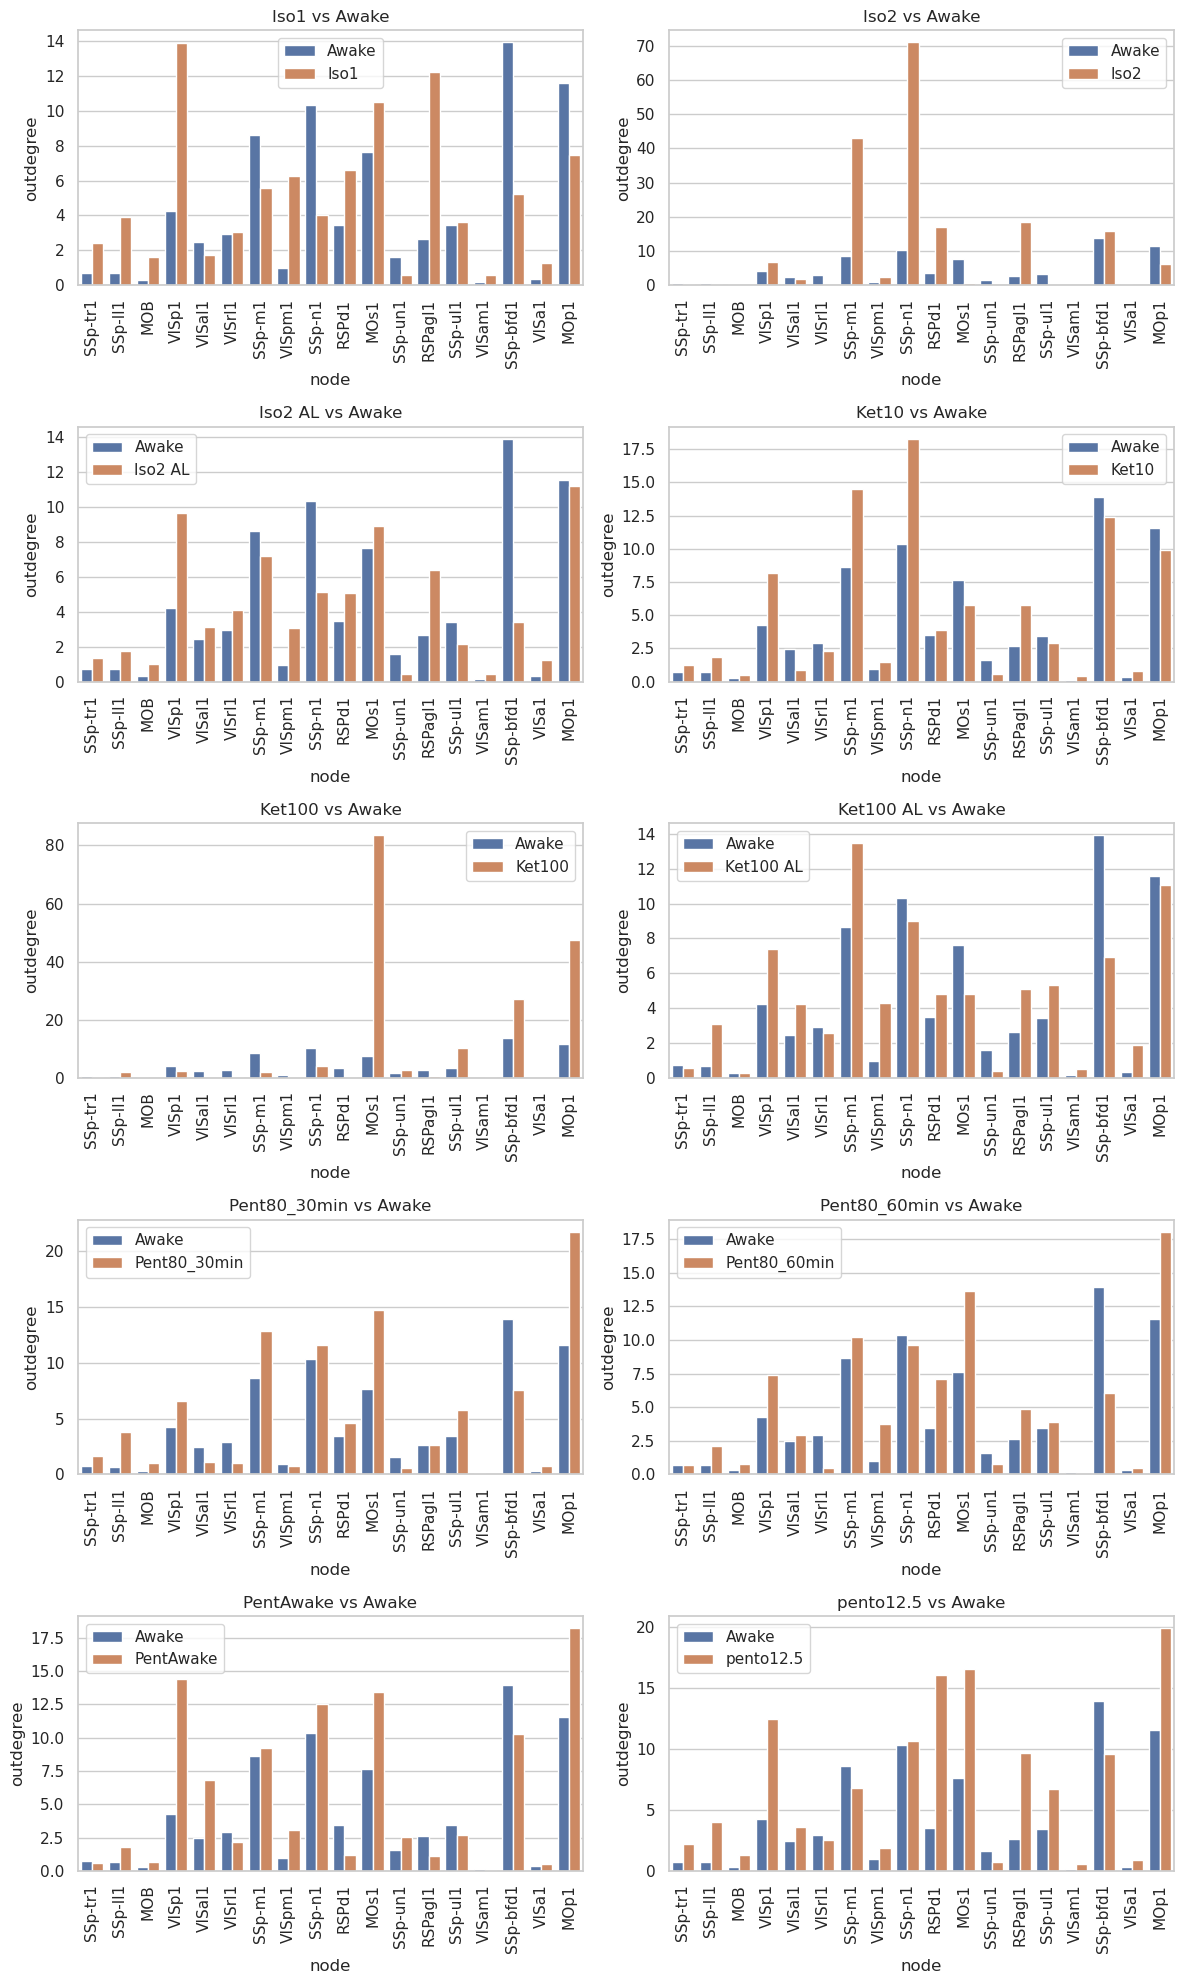

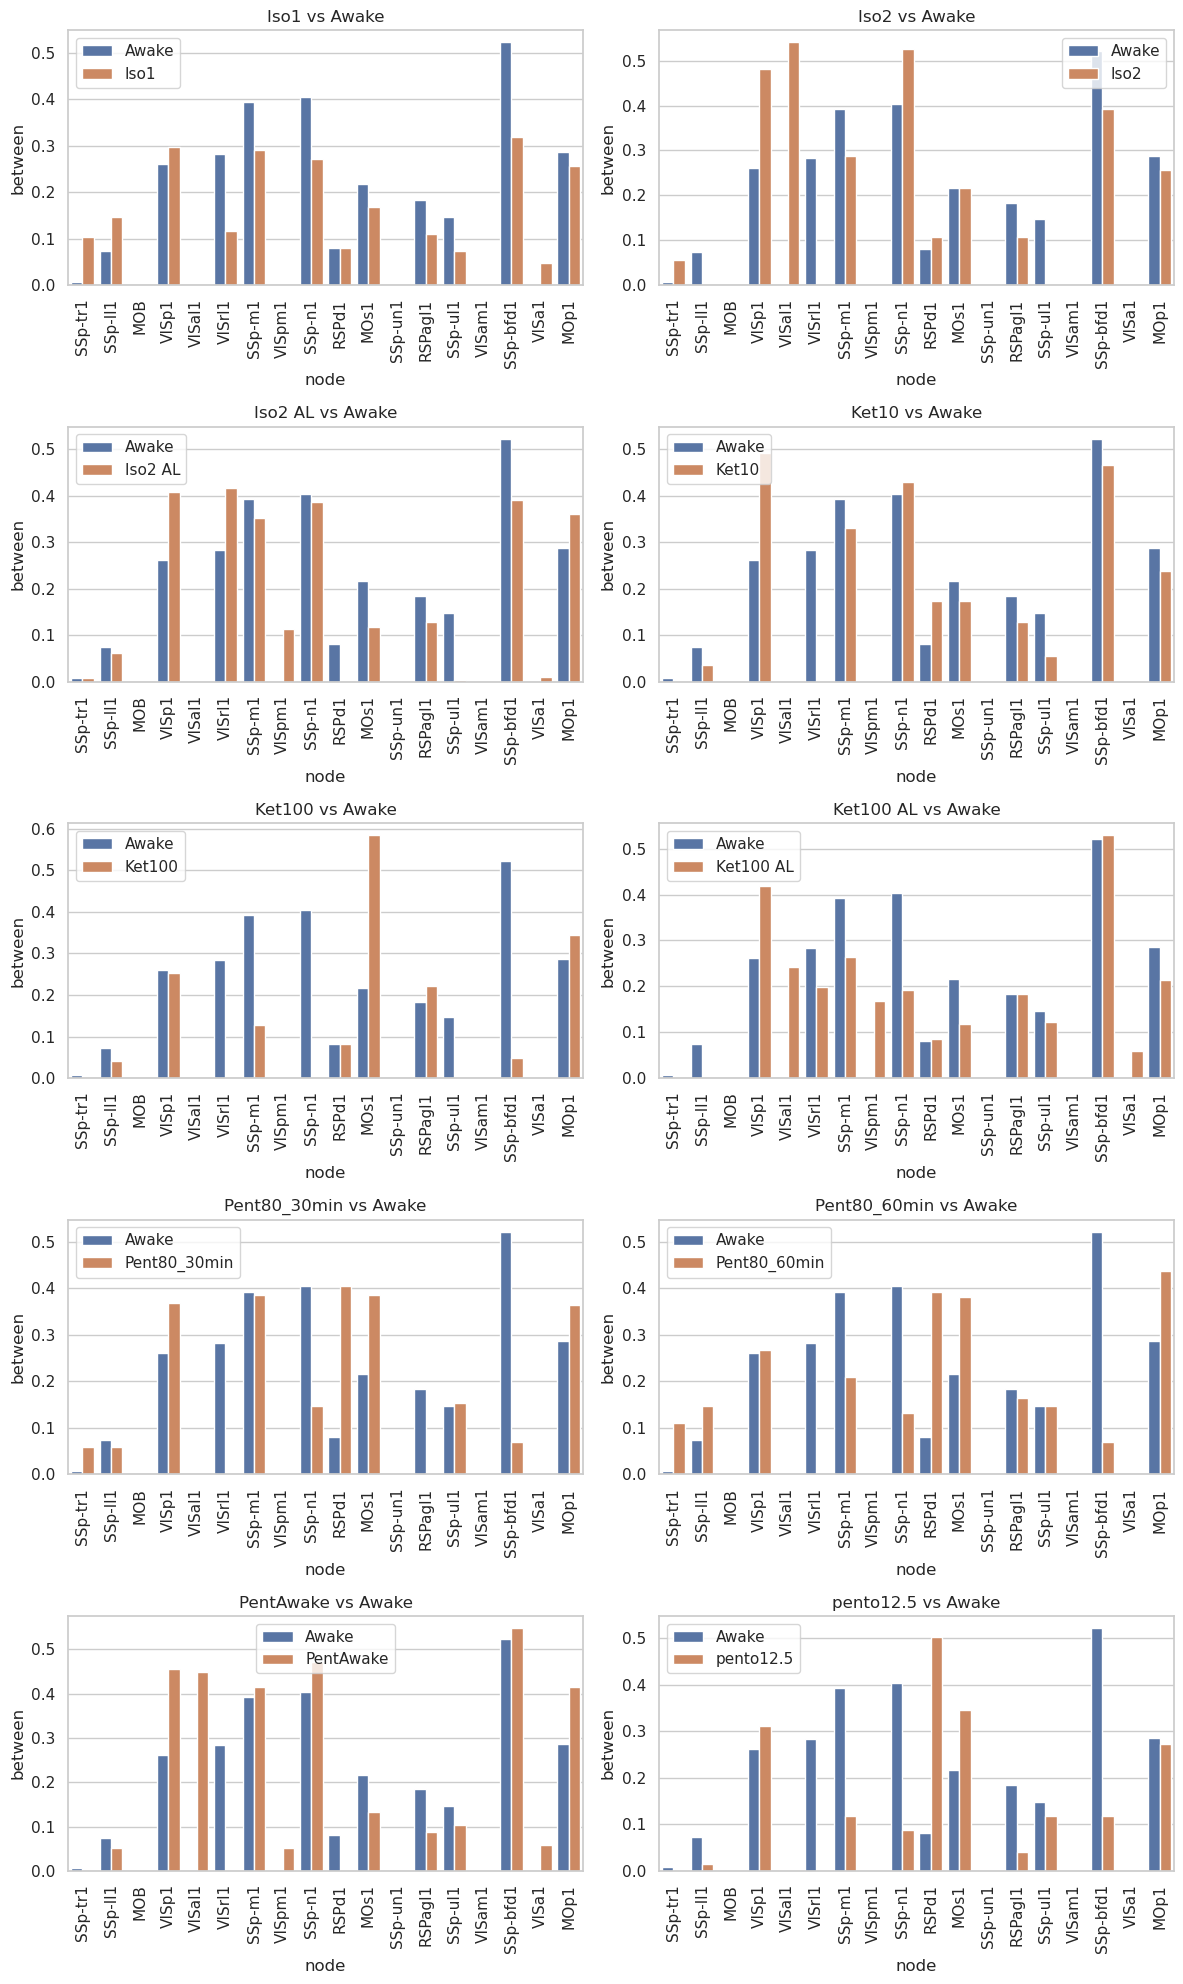

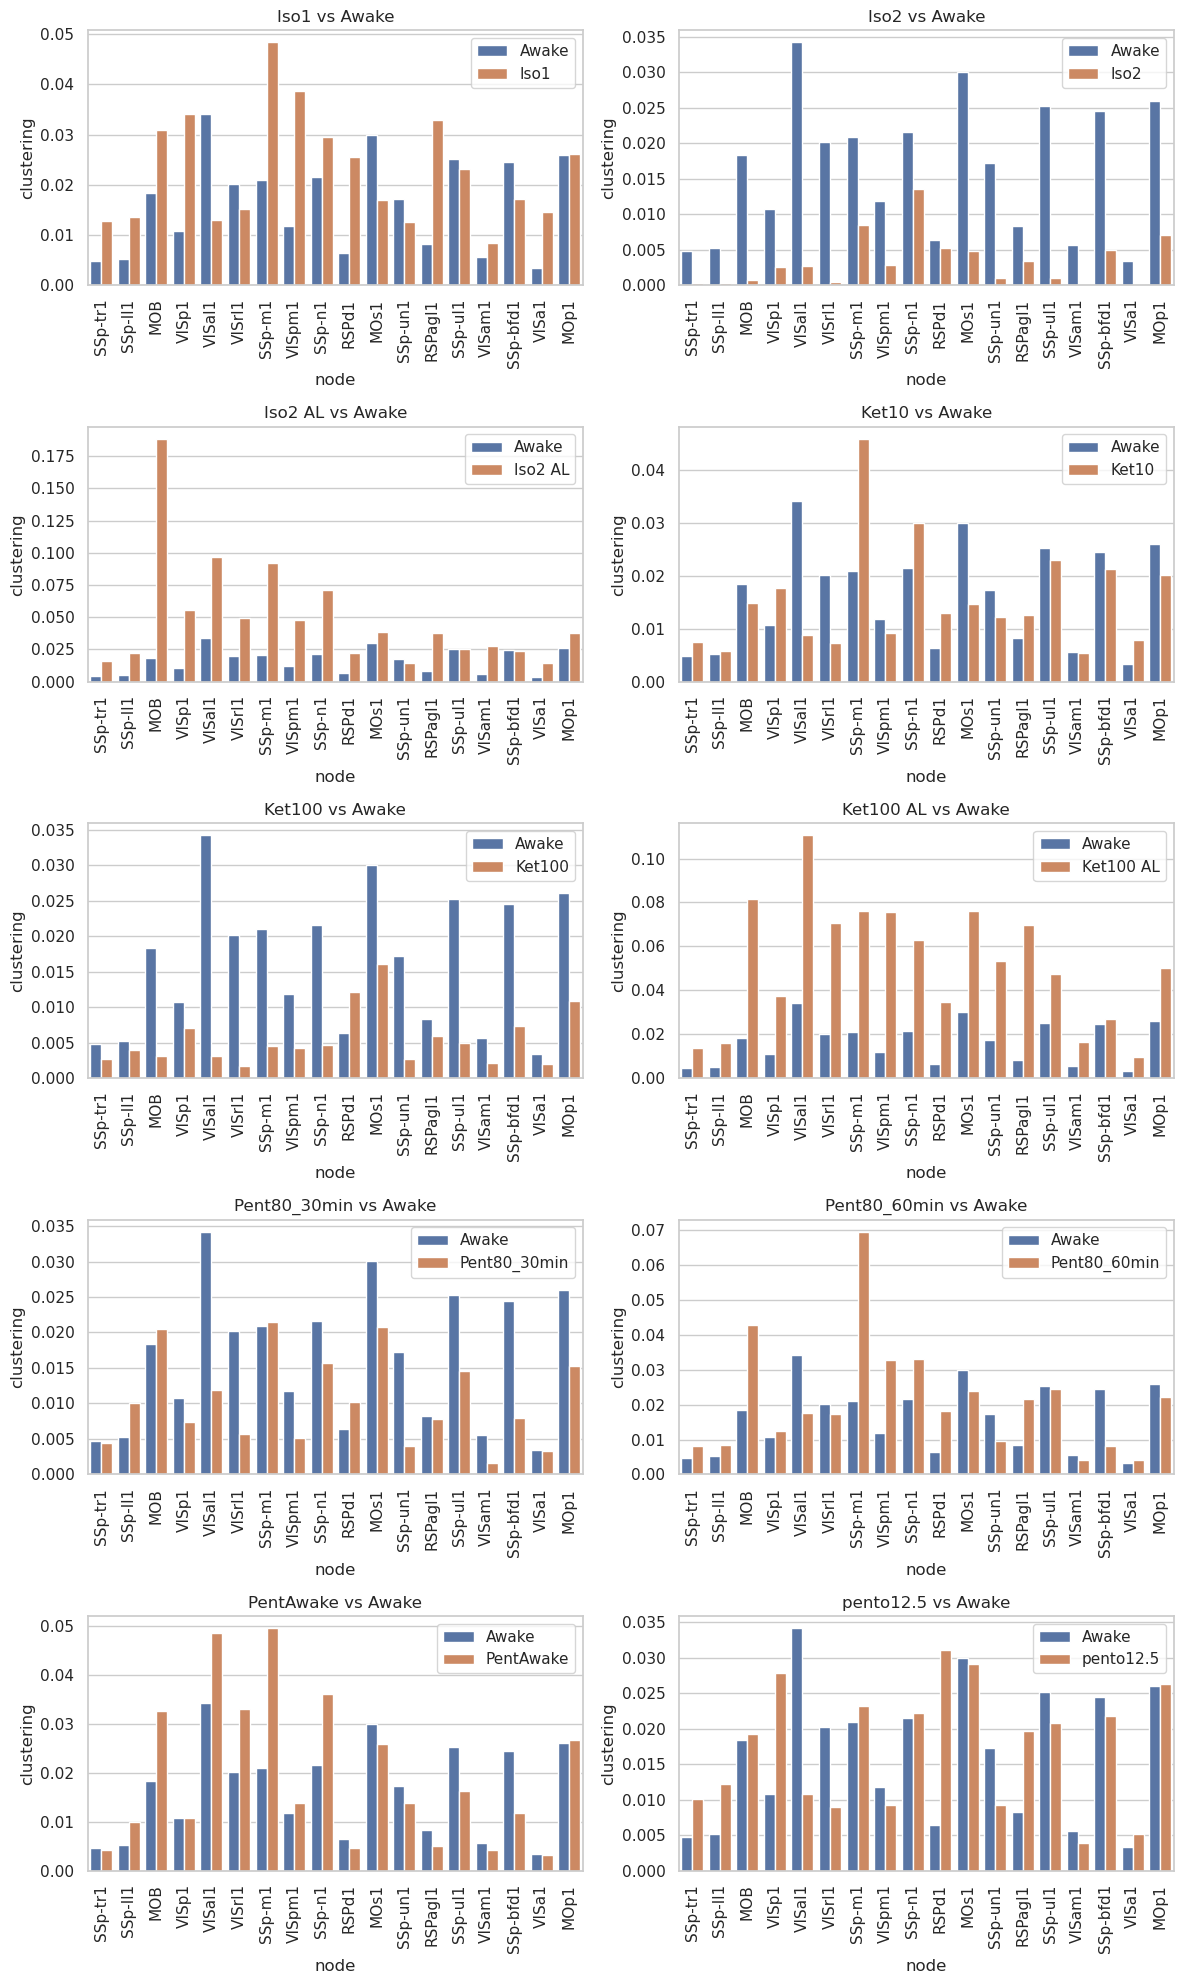

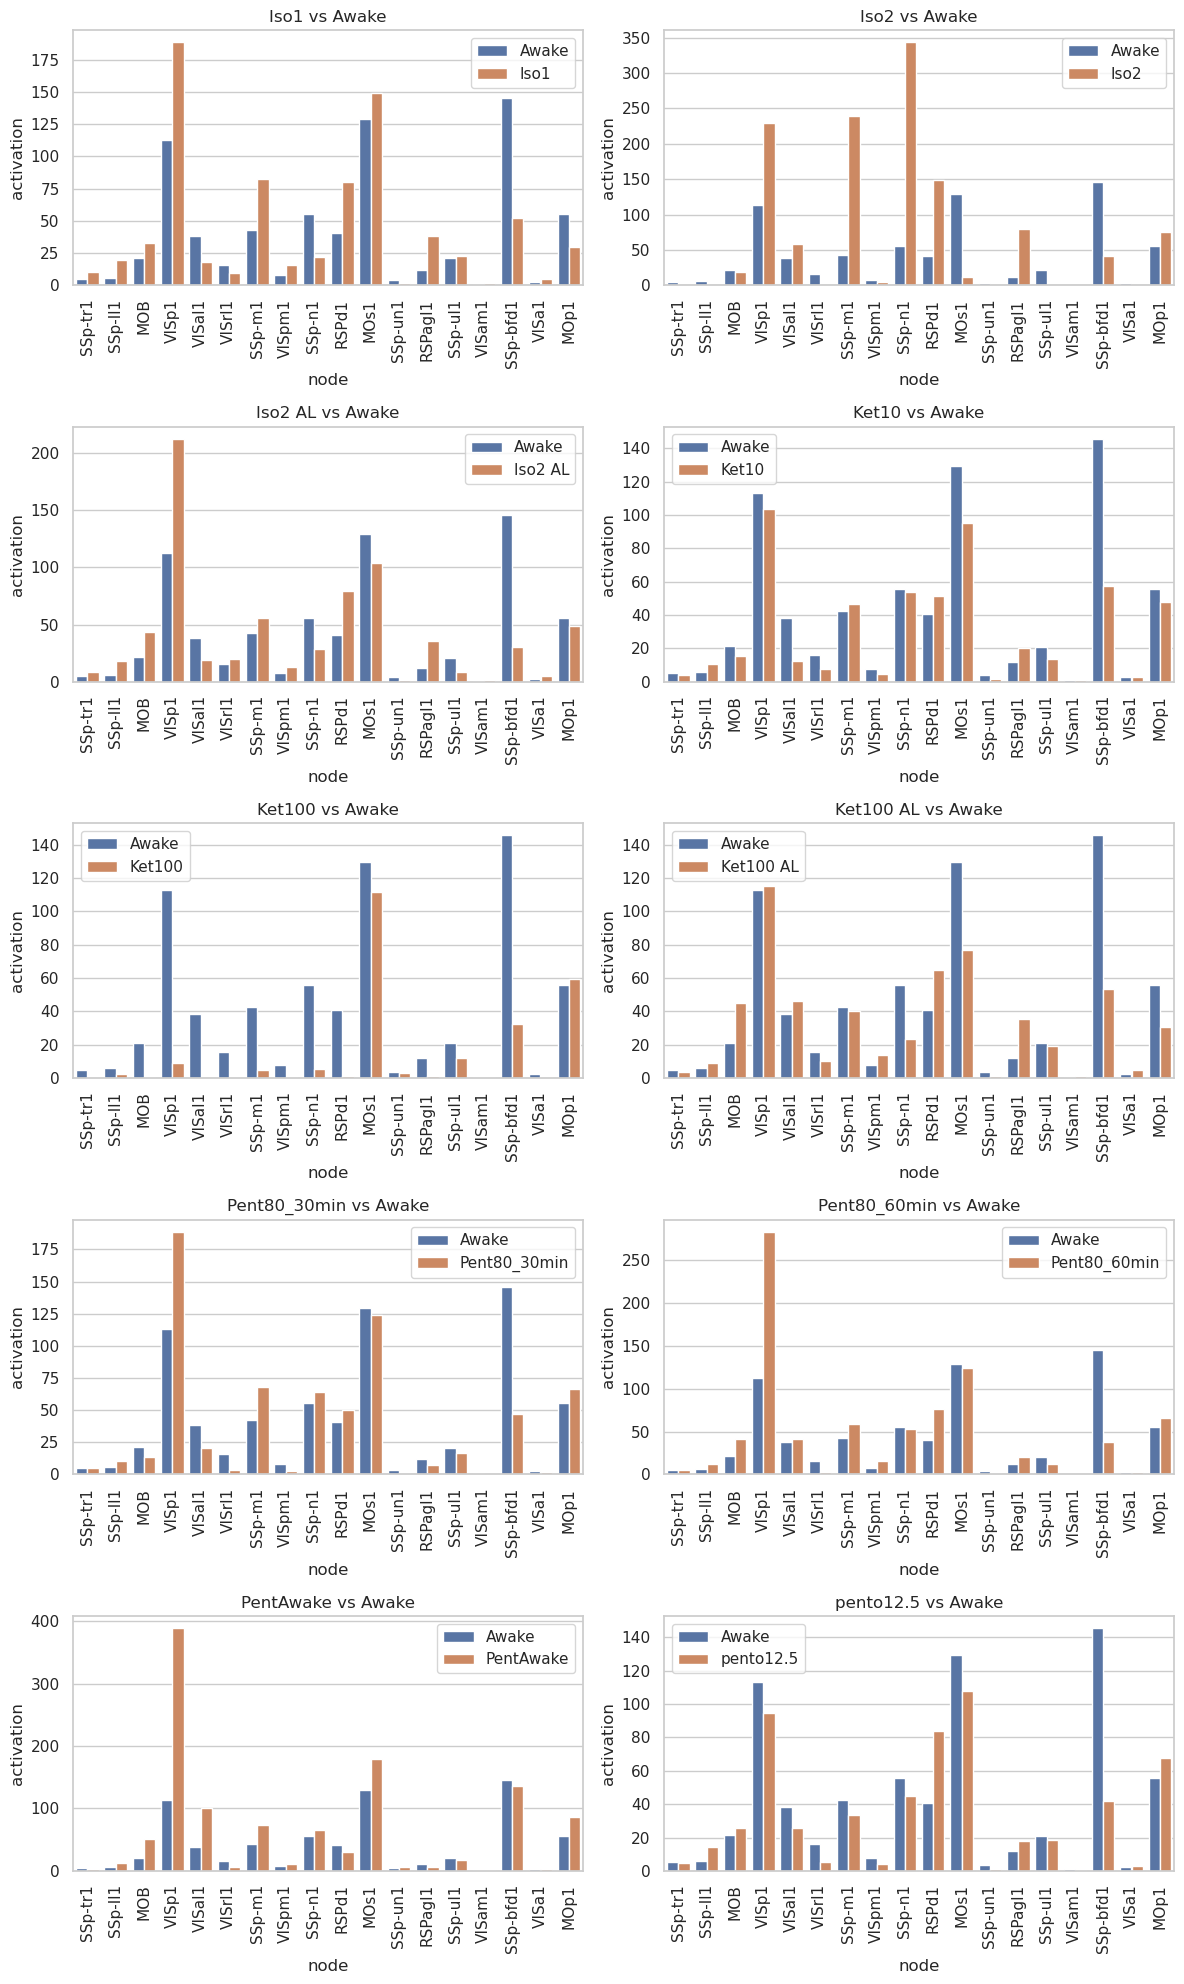

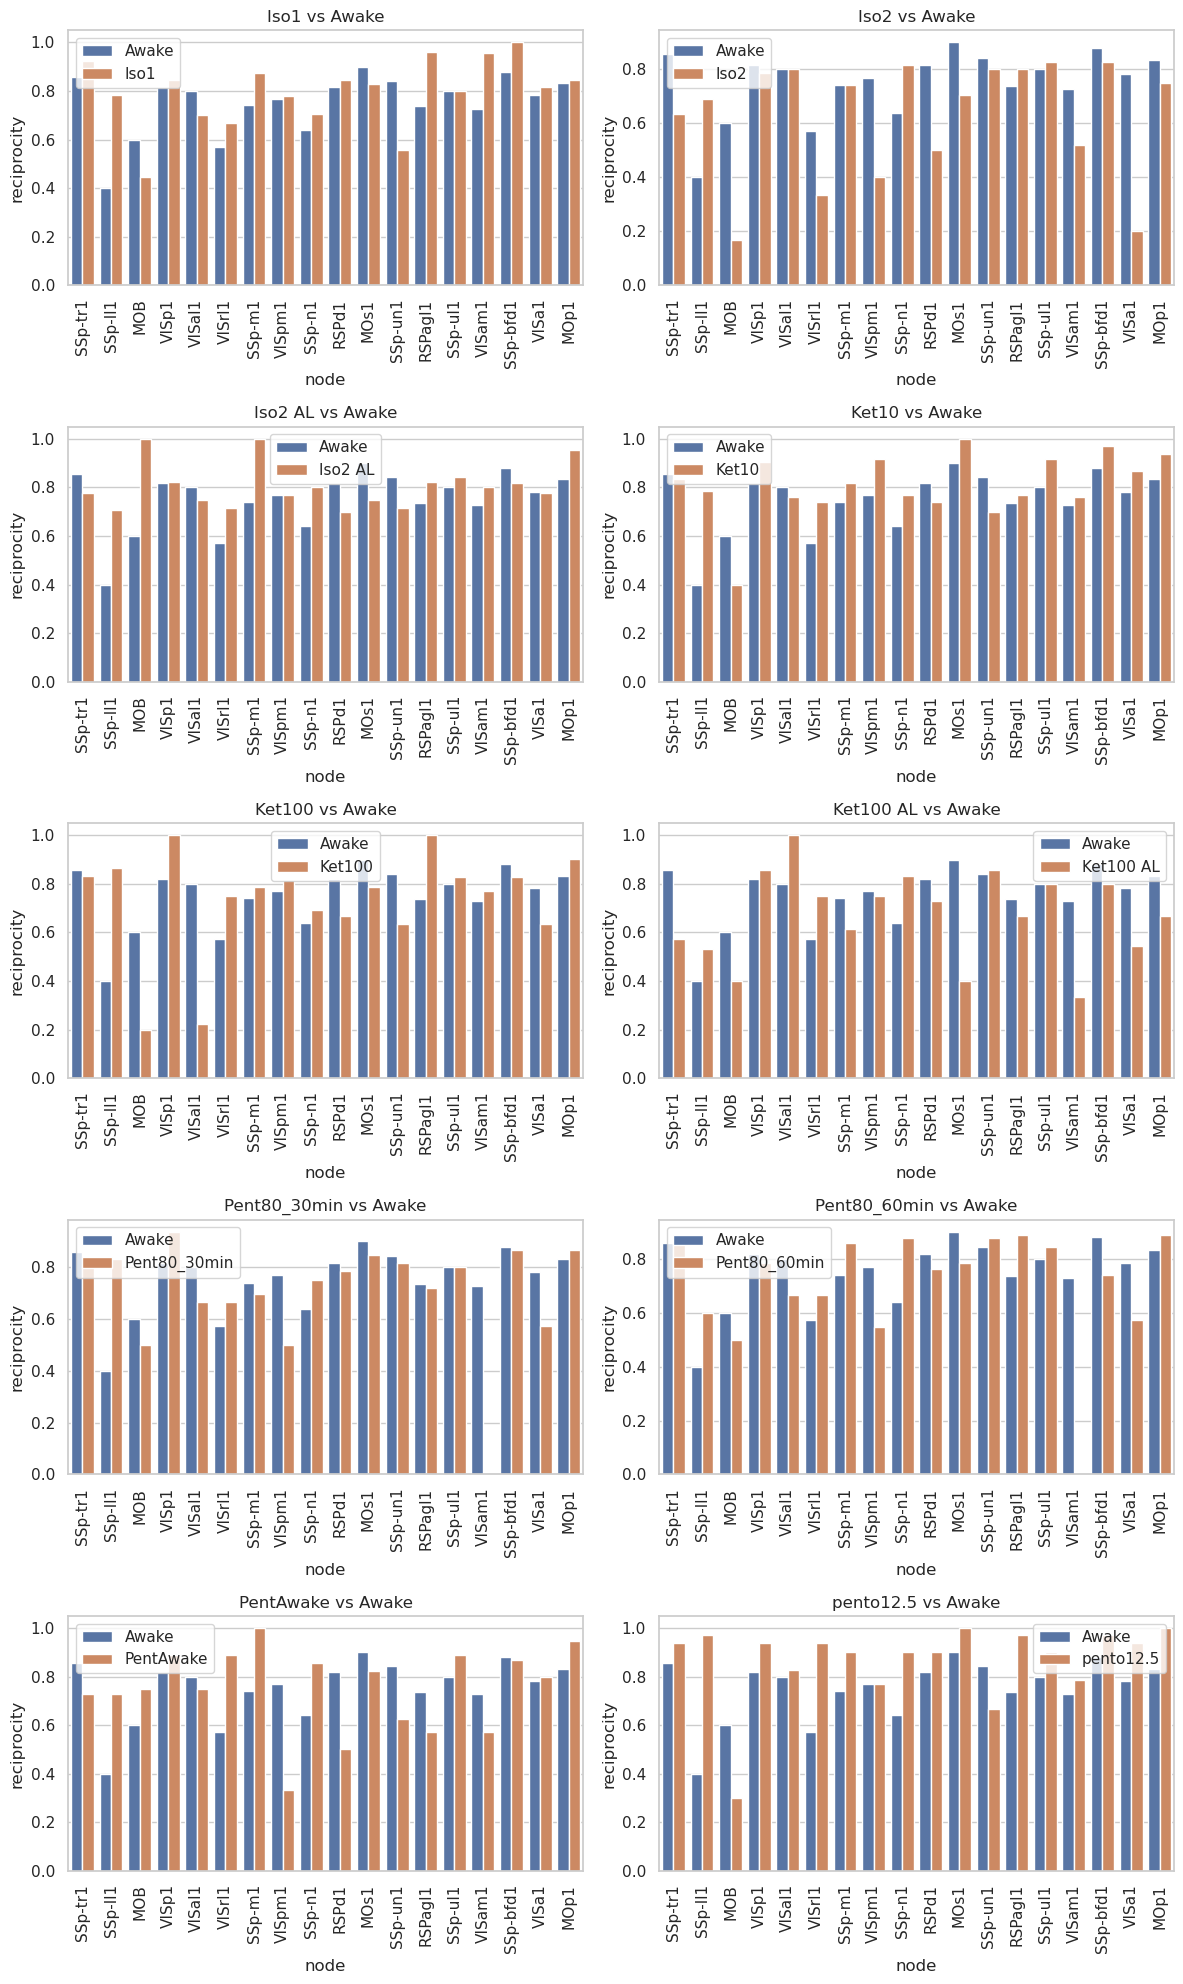

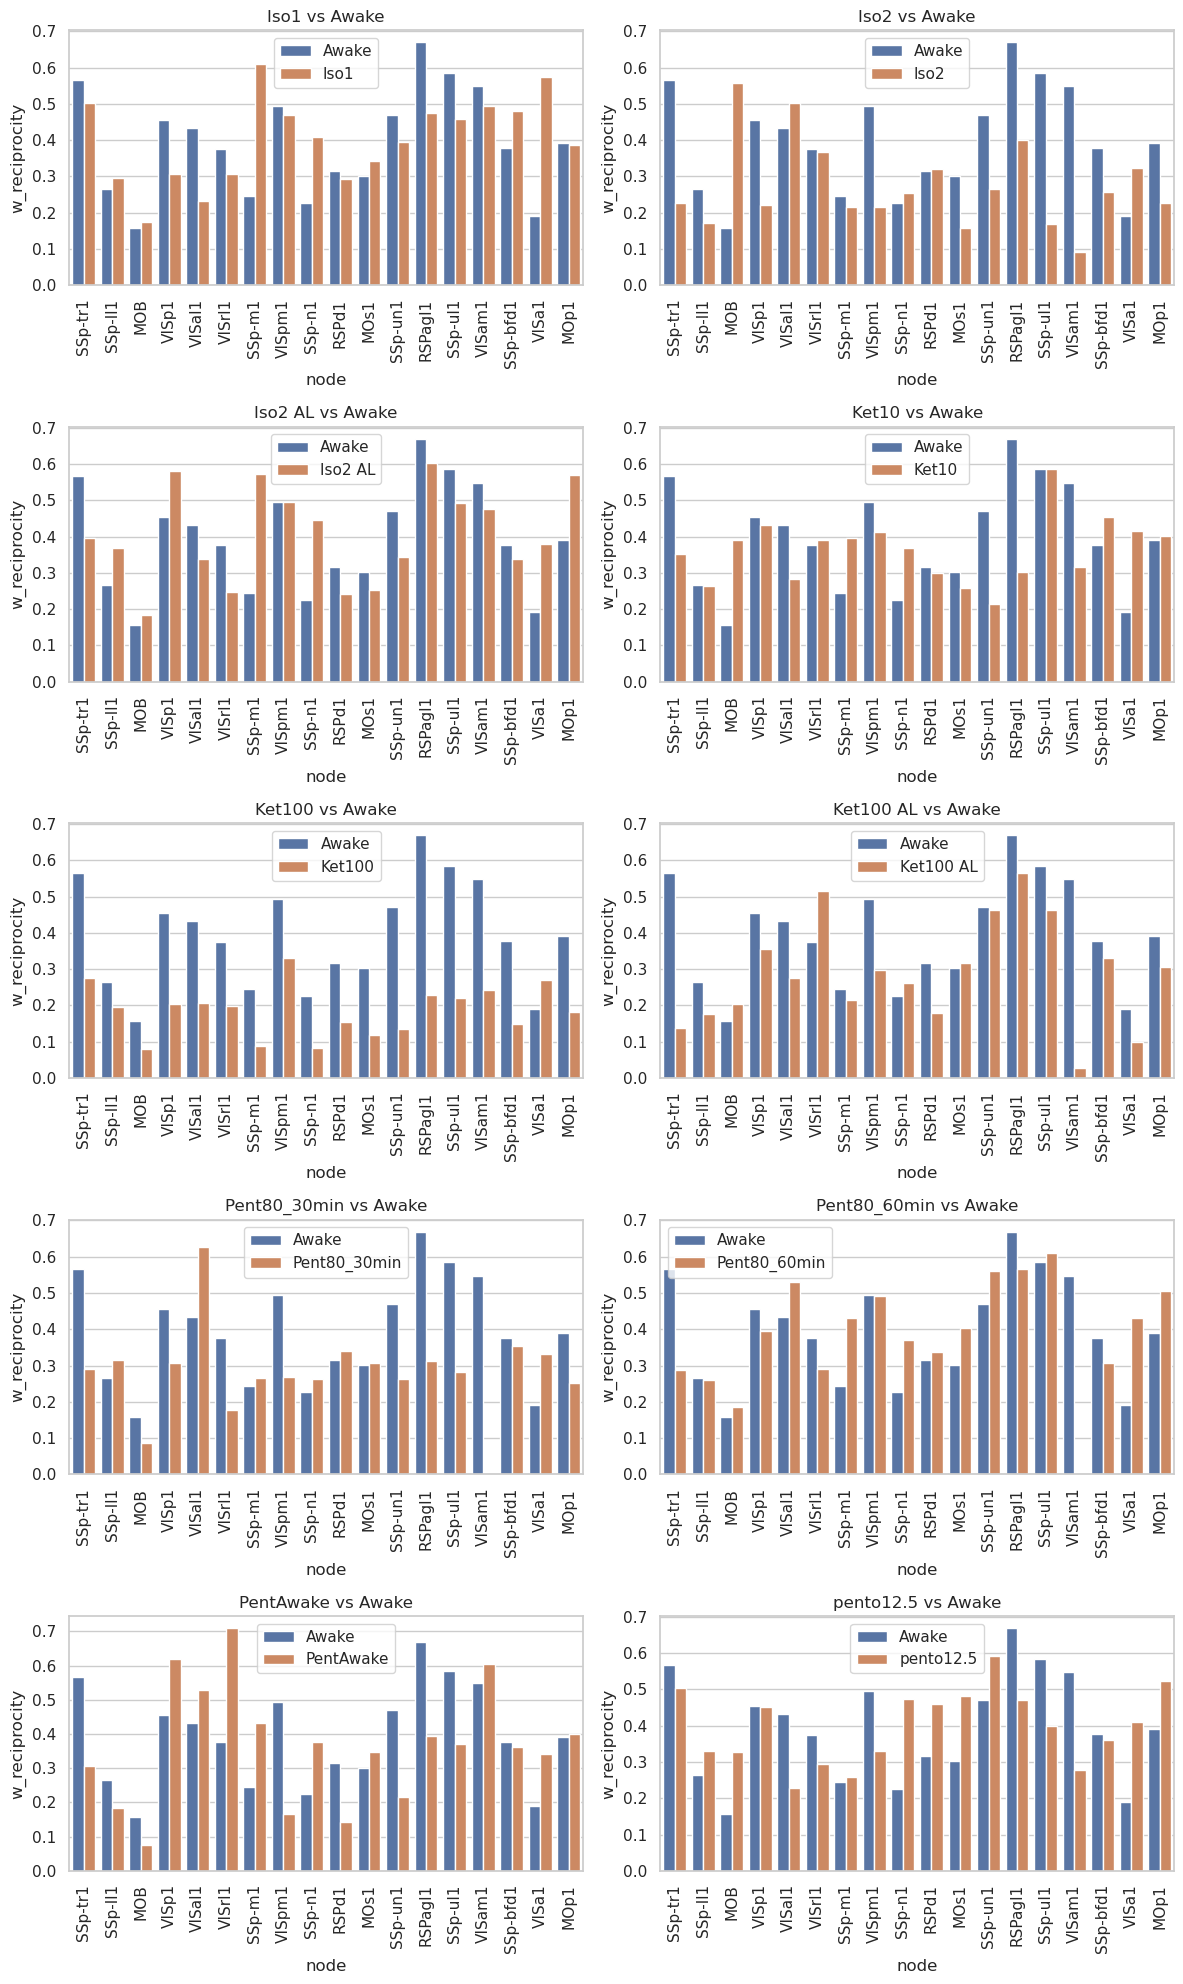

In [27]:
cols = list(node_df.columns)
[cols.remove(x) for x in ['node', 'condition']]


for metric in cols:
    
    # Ensure seaborn styling
    sns.set(style="whitegrid")
    # Get list of unique conditions (excluding baseline)
    baseline = reference
    all_conditions = node_df['condition'].unique()
    compare_conditions = [cond for cond in all_conditions if cond != baseline]
    
    # Prepare figure
    n = len(compare_conditions)
    ncols = 2
    nrows = int(np.ceil(n*1./ncols))
    
    #fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4 * nrows), sharex=False)
    
    if n == 1:
        axes = [axes]  # make iterable if only one subplot
    
    # Plot each condition vs. baseline
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows), sharex=False)
    axes = axes.flatten()  # Flatten to 1D for easy indexing
    
    for i, cond in enumerate(compare_conditions):
        ax = axes[i]
        # Subset the dataframe for baseline and current condition
        df_baseline = node_df[node_df['condition'] == baseline]
        df_current = node_df[node_df['condition'] == cond]
    
        # Merge the two on 'node' so they're aligned
        merged = pd.merge(df_baseline, df_current, on='node', suffixes=('_baseline', f'_{cond}'))
    
        # Melt for seaborn
        plot_df = pd.melt(
            merged,
            id_vars='node',
            value_vars=[metric + '_baseline', f'{metric}_{cond}'],
            var_name='source',
            value_name= metric
        )
    
        # Clean up labels for clarity
        plot_df['source'] = plot_df['source'].map({
            metric + '_baseline': baseline,
            f'{metric}_{cond}': cond
        })
    
        # Plot
        sns.barplot(data=plot_df, x='node', y= metric, hue='source', ax=ax)
        ax.set_title(f'{cond} vs {baseline}')
        ax.set_ylabel(metric)
        #ax.set_xlabel('Node')
        ax.tick_params(axis='x', rotation=90)
        ax.legend()#title='Condition')
    
    # If there are unused subplots, hide them
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])  # or axes[j].axis('off')
    
    
    plt.tight_layout()
    #plt.show()
    
    save_dir = my.check_if_dir_exists(str(result_dir / 'averaged_graphs') +'/figures/')
    fig.savefig(save_dir + 'nodes_metric=' + metric + '_againstref=' + reference +  '.png')


In [40]:
with open(str(result_dir / 'averaged_graphs') + '/avg_graphs_meta.pkl', 'rb') as f:
    avg_graphs_meta = pickle.load(f)  

node_df = pd.read_csv(avg_graphs_meta['nodedf']['path'] + '.csv')

graphs = dict()
for key in avg_graphs_meta['avg_graph'].keys():
    G = nx.read_gml(avg_graphs_meta[load_name][key]['path'] + '.' + avg_graphs_meta[load_name][key]['format'])
    graphs[key] = G

In [44]:
cols = list(node_df.columns)
[cols.remove(x) for x in ['node', 'condition', 'Unnamed: 0']]


key = list(graphs.keys())
df = pd.DataFrame({'keys' : key})
metric_list = list()

for key in graphs.keys():
    G = graphs[key]
    #print(key,nx.is_strongly_connected(G))
       
    # Get the edge weights for each edge in the graph
    weights = list(nx.get_edge_attributes(G, 'weight').values())
    X = weights 
    tag = 'weight'
    metric_list.append(tag)
    df = my.get_stats(X, tag, key, df)
    
    
    #get pre-calculated node stats
    for c in cols:
        X = [G.nodes[node][c] for node in list(G.nodes())]
        df = my.get_stats(X, c, key, df)
        metric_list.append(c)
    

    #get gini coefficient
    X = my.gini(weights)
    tag = 'gini'
    metric_list.append(tag)
    df = my.get_stats(X, tag, key, df)

    #get average shortest path
    if nx.is_strongly_connected(G):
        X = nx.average_shortest_path_length(G, weight = lambda x,y,z: 1/z['weight'])
        tag = 'ASPL'
        metric_list.append(tag)
        df = my.get_stats(X, tag, key, df)
    else:
        g_strong = G.copy()
        X = 0
        tag = 'ASPL'
        metric_list.append(tag)
        df = my.get_stats(X, tag, key, df)
        
metric_list = list(set(metric_list))        
df.head()




#save the node_df file
save_name = 'avg_graph_stats_df'
save_dir = str(result_dir / 'averaged_graphs')
avg_graphs_meta[save_name] = {'path': str(save_dir) + '/' + save_name,
                                    'save_dir': str(save_dir),
                                    'save_name': save_name,
                                    'format' : 'csv',
                                    'num_cols' : df.shape[1],
                                    'num_rows' : df.shape[0],
                                    'metric_list': metric_list
                                   }

df.to_csv(avg_graphs_meta[save_name]['path'] + '.csv')



In [52]:
with open(str(result_dir / 'averaged_graphs') + '/avg_graphs_meta.pkl', 'rb') as f:
    avg_graphs_meta = pickle.load(f)  

df = pd.read_csv(avg_graphs_meta['avg_graph_stats_df']['path'] + '.csv')
metric_list = avg_graphs_meta['avg_graph_stats_df']['metric_list']

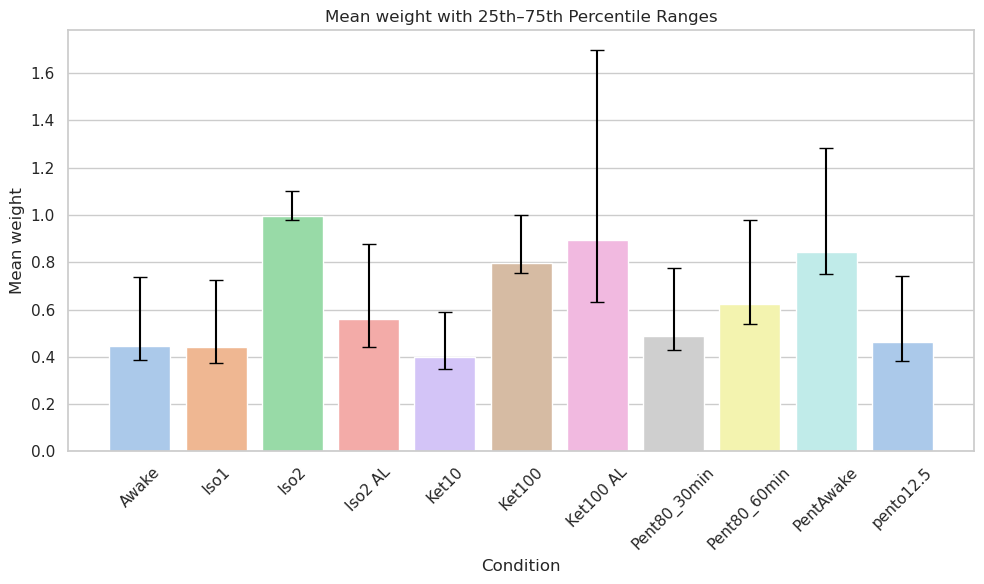

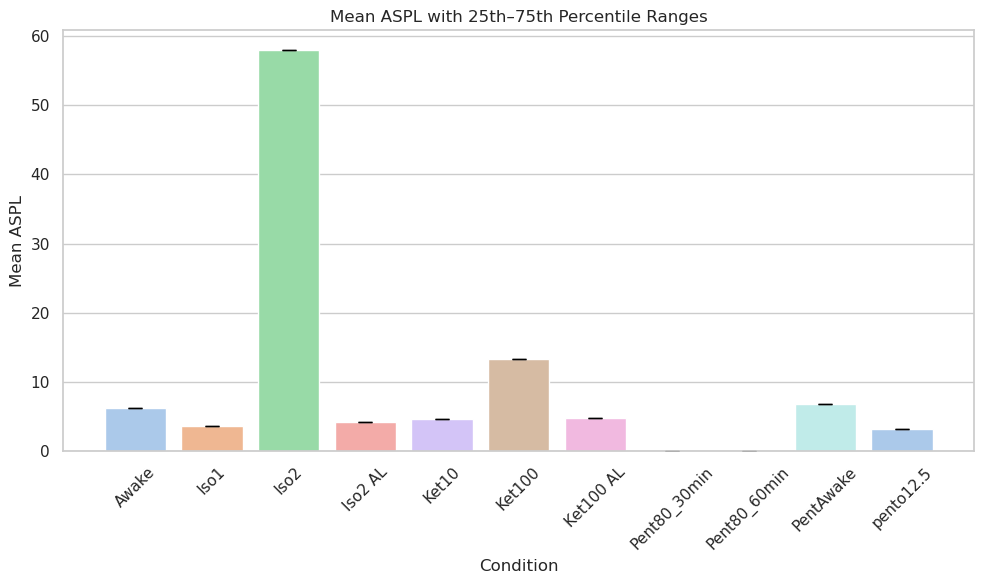

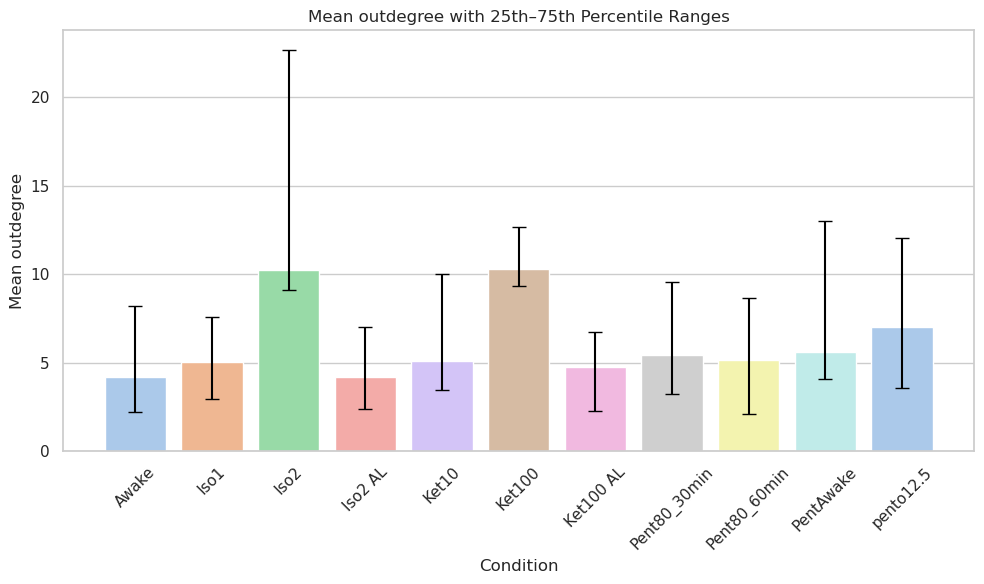

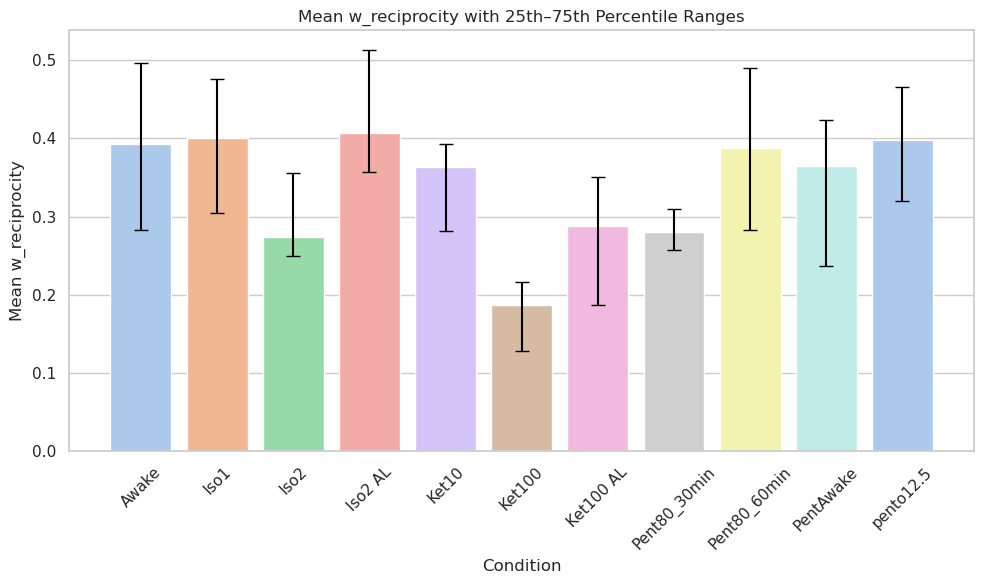

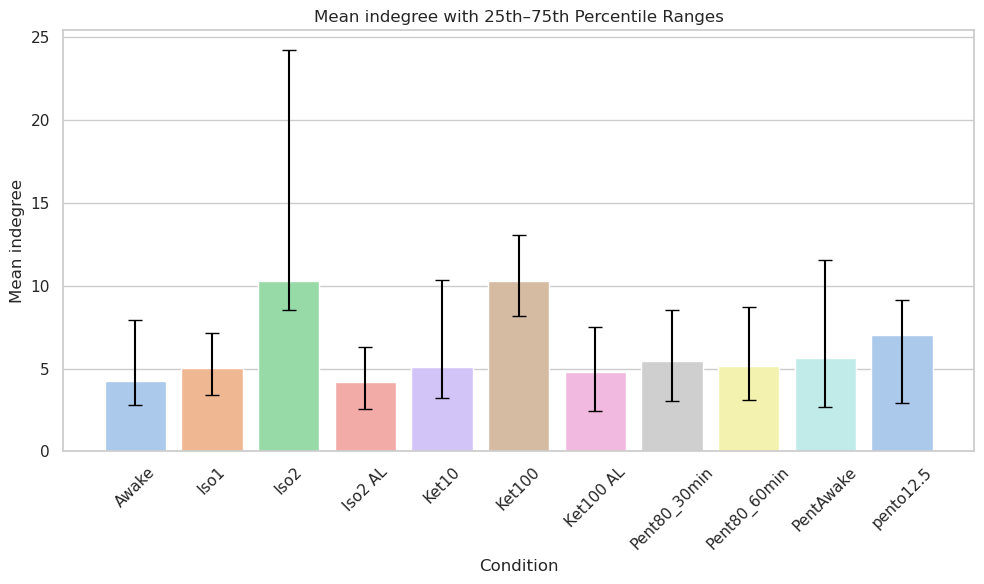

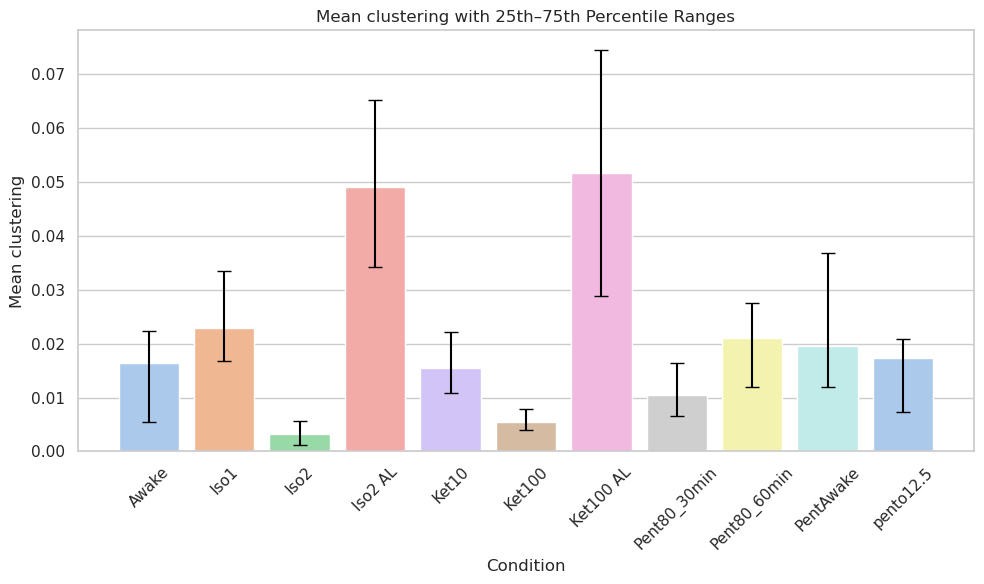

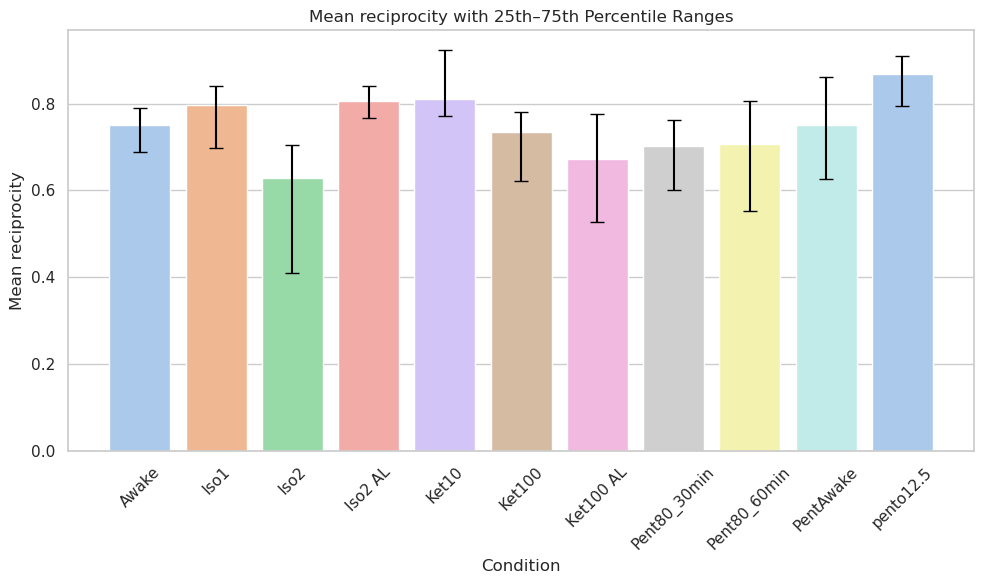

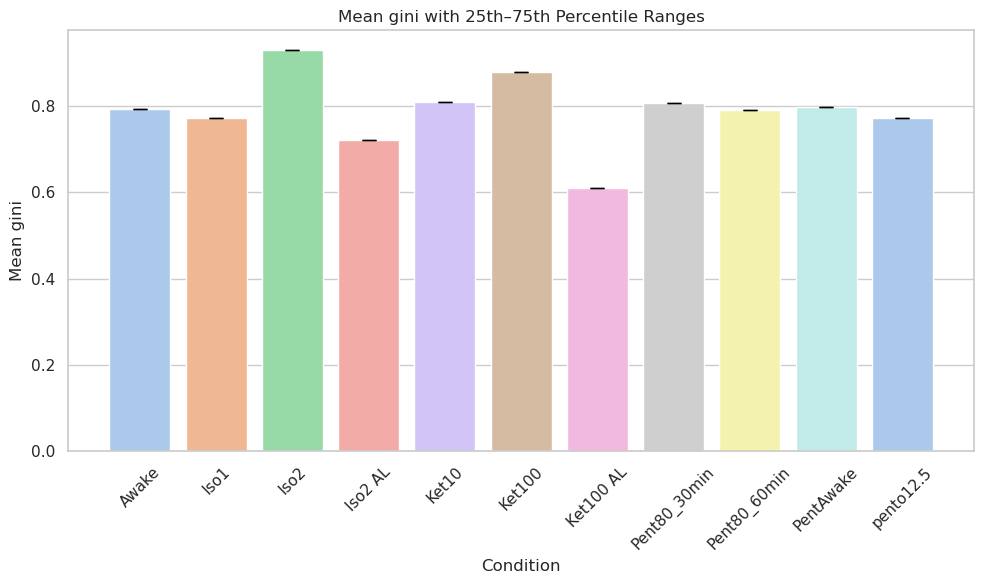

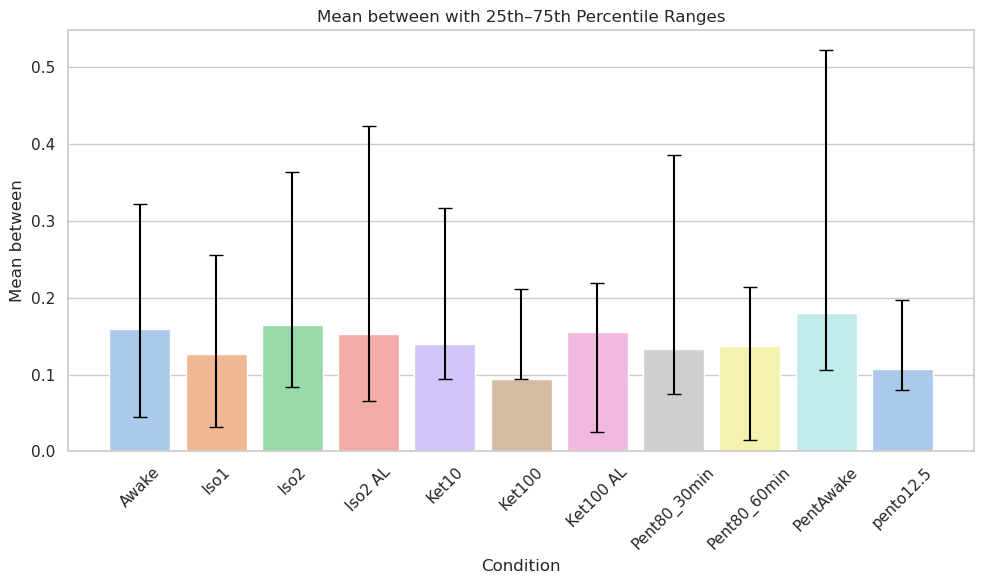

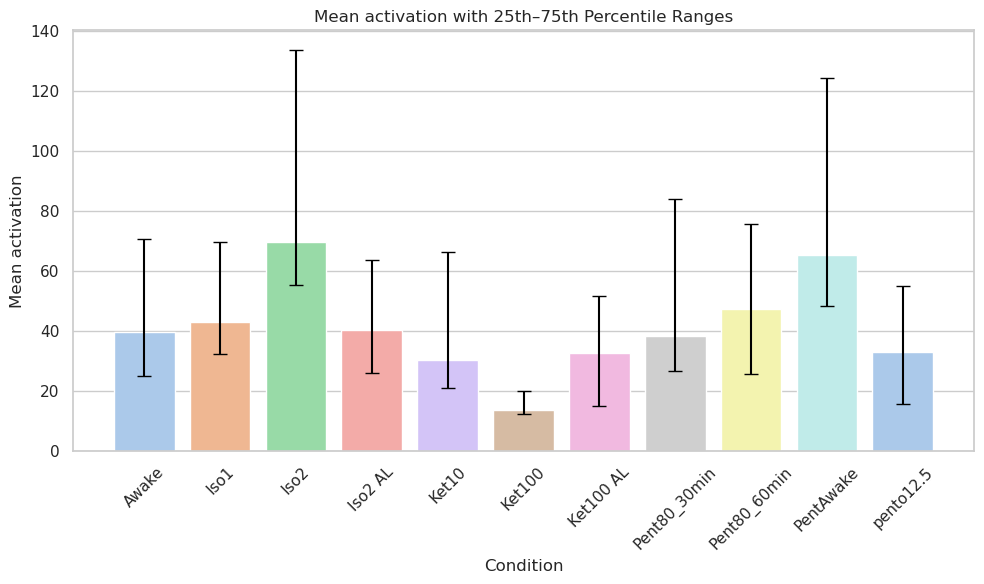

In [56]:

for metric in metric_list:
    # Create figure and axis
    plt.figure(figsize=(10, 6))
    
    # Make the barplot but disable CI/errorbars
    barplot = sns.barplot(data=df, x='keys', y= metric + '_mean',  errorbar=None, hue = 'keys', palette='pastel')
    
    # Add error bars manually
    # Get the positions of the bars
    x_coords = []
    for bars in barplot.containers:
        for bar in bars:
            x = bar.get_x() + bar.get_width() / 2
            x_coords.append(x)
    x_coords = np.sort(x_coords)
    
    
    # Extract error values
    yerr_lower = df[metric + '_25th'].values
    yerr_upper = df[metric + '_75th'].values
    yerr = [yerr_lower, yerr_upper]
    
    # Add error bars
    plt.errorbar(x_coords, df[metric + '_mean'], yerr=yerr, fmt='none', ecolor='black', capsize=5)
    
    # Final touches
    plt.xlabel('Condition')
    plt.ylabel('Mean ' + metric)
    plt.title('Mean ' + metric + ' with 25th–75th Percentile Ranges')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    fig = barplot.get_figure()
    save_dir = my.check_if_dir_exists(str(result_dir / 'averaged_graphs') +'/figures/')
    fig.savefig(save_dir + 'avg_graph_metric_barplots=' + metric + '.png')

In [70]:
with open(str(result_dir / 'averaged_graphs') + '/avg_graphs_meta.pkl', 'rb') as f:
    avg_graphs_meta = pickle.load(f)  

graphs = dict()
for key in avg_graphs_meta['avg_graph'].keys():
    G = nx.read_gml(avg_graphs_meta[load_name][key]['path'] + '.' + avg_graphs_meta[load_name][key]['format'])
    graphs[key] = G

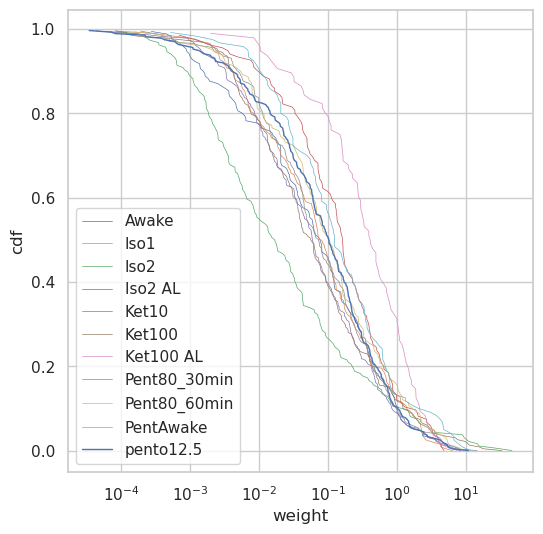

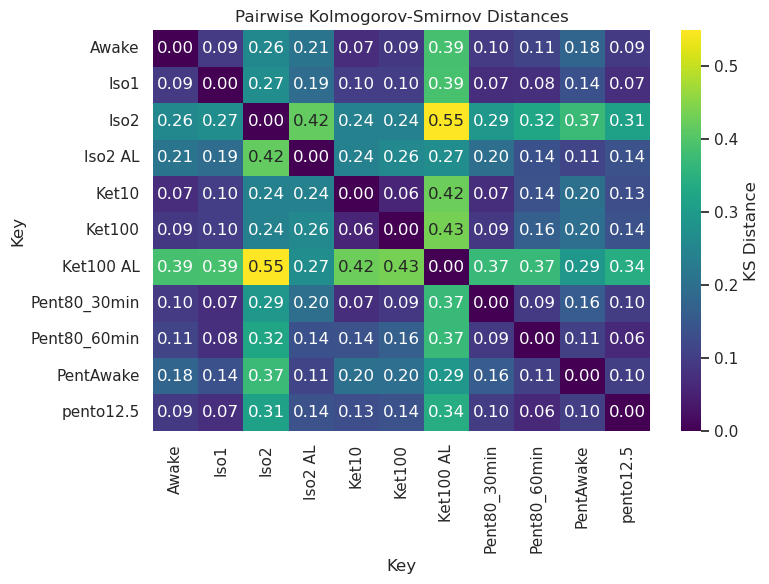

In [110]:
import seaborn as sns
from scipy.stats import ks_2samp


def plot_ks_distance_matrix(weights):
    keys = list(weights.keys())
    n = len(keys)
    
    # Initialize matrix to store KS distances (D-statistic)
    ks_distances = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i <= j:  # Compute upper triangle and diagonal
                d_stat, _ = ks_2samp(weights[keys[i]], weights[keys[j]])
                ks_distances[i, j] = d_stat
                ks_distances[j, i] = d_stat  # Symmetric matrix
    
    # Create heatmap
    plt.figure(figsize=(8, 6))
    snsplot = sns.heatmap(ks_distances, xticklabels=keys, yticklabels=keys,
                annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'KS Distance'})
    plt.title("Pairwise Kolmogorov-Smirnov Distances")
    plt.xlabel("Key")
    plt.ylabel("Key")
    plt.tight_layout()
    fig = snsplot.get_figure()
    return fig
    


# plot weight distribution for each graph
plt.figure(figsize=(6,6))
colorcount = 0
lw = .5
dat = dict()
for i,key in enumerate(graphs.keys()):
    # Load the graph from the dictionary using its key
    G = graphs[key]
    weights = nx.get_edge_attributes(G, 'weight')

    dat[key] = list(weights.values())
    res = stats.ecdf(dat[key])

    #if the colours start to repeat then up the linewidth
    if colorcount > 9:
        lw += .5
        colorcount = 0
        
    fig = plt.plot(res.cdf.quantiles, 1-res.cdf.probabilities, label = key, lw = lw)
    colorcount += 1


plt.legend()
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('weight');
plt.ylabel('cdf');


fig = plt.gcf()
save_dir = my.check_if_dir_exists(str(result_dir / 'averaged_graphs') +'/figures/')
fig.savefig(save_dir + 'weights_cdf' + '.png')


fig = plot_ks_distance_matrix(dat)
save_dir = my.check_if_dir_exists(str(result_dir / 'averaged_graphs') +'/figures/')
fig.savefig(save_dir + 'pairwise_KS_distance_matrix' + '.png')


In [ ]:
for key in np.unique(df['keys']):
    my.draw_weighted_graph(graphs[key], title = key, figsize = (1,1))

In [122]:
with open(str(result_dir / 'averaged_graphs') + '/avg_graphs_meta.pkl', 'rb') as f:
    avg_graphs_meta = pickle.load(f)  

node_df = pd.read_csv(avg_graphs_meta['nodedf']['path'] + '.csv')
cols = list(node_df.columns)
[cols.remove(x) for x in ['node', 'condition', 'Unnamed: 0']]


graphs = dict()
for key in avg_graphs_meta['avg_graph'].keys():
    G = nx.read_gml(avg_graphs_meta['avg_graph'][key]['path'] + '.' + avg_graphs_meta['avg_graph'][key]['format'])
    graphs[key] = G

NameError: name 'stop' is not defined

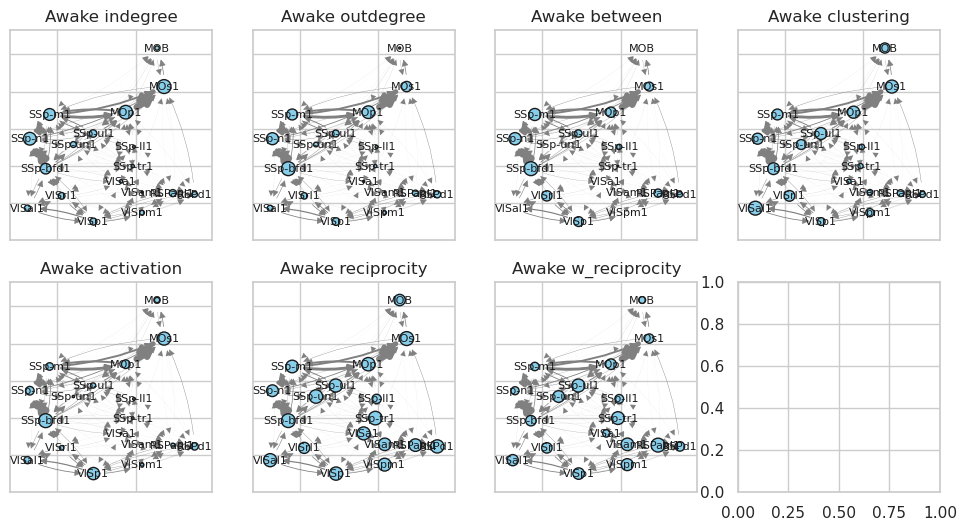

<Figure size 100x100 with 0 Axes>

<Figure size 100x100 with 0 Axes>

<Figure size 100x100 with 0 Axes>

<Figure size 100x100 with 0 Axes>

<Figure size 100x100 with 0 Axes>

<Figure size 100x100 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [126]:
n = len(graphs.keys())
ncols = len(cols)
nrows = n#int(np.ceil(n / ncols))

#fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows), sharex=False)
#axes = axes.flatten()  # Flatten to 1D for easy indexing

plotting_fac = 100;

count = 0
for i,key in enumerate(graphs.keys()):
    #if i >0:
        #continue
    #plt.sca(axes[i])
    G = graphs[key]
    # #get in degree stats

    nrows = int(np.ceil(3./4*np.sqrt(len(cols))))
    ncols = int(np.ceil(4./3*np.sqrt(len(cols))))
                
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows), sharex=False);
    axes = axes.flatten() ; # Flatten to 1D for easy indexing
    count = 0
    
    for c in cols:
        node_size = np.array([G.nodes[node][c] for node in list(G.nodes())])
        node_size = plotting_fac*node_size/max(node_size)
        my.draw_weighted_graph(G, node_size = node_size, title = key + ' ' + c, figsize = (1,1), ax = axes[count]);
        count += 1


    plt.tight_layout();
    #fig = plt.gcf()

    
    save_dir = my.check_if_dir_exists(result_dir / 'averaged_graphs' / key )
    save_name = 'avg_graphs_nodes_weighted_metric'        
    #save the figure
    fig.savefig(str(save_dir) + '/' + save_name + '.png')
    stop



In [486]:
cols = list(node_df.columns)
[cols.remove(x) for x in ['node', 'condition']]
surr_df = pd.DataFrame(columns = cols)

key = 'Ket100'
n_surrogates = 20
G_surr = my.generate_multiple_surrogates(graphs[key], n_surrogates = n_surrogates, seed=None)
for k in range(n_surrogates):
    stats_df, G_surr[k] = my.calculate_node_proprties(G_surr[k], key)
    mean_df = stats_df.drop(['node', 'condition'], axis = 1).mean()
    row = {x:y for (x,y) in zip(list(mean_df.keys()),mean_df.values)}
    row = pd.DataFrame(row, index = [k])
    surr_df = pd.concat([surr_df, row])
surr_df.head(20)

/tmp/ipykernel_3577334/2901361749.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surr_df = pd.concat([surr_df, row])


,indegree,outdegree,between,clustering,activation,reciprocity,w_reciprocity
0,10.293387,10.293387,0.151552,0.003966,13.680556,0.734322,0.201995
1,10.293387,10.293387,0.182802,0.003599,13.680556,0.734322,0.206708
2,10.293387,10.293387,0.145425,0.003781,13.680556,0.734322,0.200806
3,10.293387,10.293387,0.133374,0.003875,13.680556,0.734322,0.188667
4,10.293387,10.293387,0.144199,0.003767,13.680556,0.734322,0.183166
5,10.293387,10.293387,0.152165,0.004114,13.680556,0.734322,0.189313
6,10.293387,10.293387,0.109886,0.003883,13.680556,0.734322,0.202710
7,10.293387,10.293387,0.152574,0.003685,13.680556,0.734322,0.150431
8,10.293387,10.293387,0.121324,0.003688,13.680556,0.734322,0.186748
9,10.293387,10.293387,0.125613,0.003870,13.680556,0.734322,0.176512


In [488]:

mean_df = node_df[node_df['condition'] == key]
mean_df = mean_df.drop(['node', 'condition'], axis = 1).mean()
mean_df = {x:y for (x,y) in zip(list(mean_df.keys()),mean_df.values)}
mean_df = pd.DataFrame(mean_df, index = [0])
mean_df.head()


,indegree,outdegree,between,clustering,activation,reciprocity,w_reciprocity
0,10.293387,10.293387,0.094567,0.005495,13.680556,0.734322,0.186821
